## 1. Introduction

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossman has provided historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the train set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Data Fields
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
# Import tools: pandas, numpy, seaborn, matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [10, 7]

In [6]:
# Read data train.csv
train = pd.read_csv('train.csv')

In [7]:
# Show first 5 rows
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [10]:
# Convert "date" column to datetime64 type
# and use this column as index later
train['Date'] = pd.to_datetime(train['Date'], format = "%Y.%m.%d")

## 2. Exploratory Data Analysis

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [13]:
# Check for null value
train.isnull().values.any()

False

In [15]:
# Get statical view of our dataset
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
# Watch for item_price less than 0
train[train['Sales'] < 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [24]:
train.groupby("Open")["Sales"].sum()

Open
0             0
1    5873180623
Name: Sales, dtype: int64

In [25]:
train.groupby("DayOfWeek")["Sales"].sum()

DayOfWeek
1    1130203012
2    1020411930
3     954962863
4     911177709
5     980555941
6     846317735
7      29551433
Name: Sales, dtype: int64

In [26]:
train.groupby("Promo")["Sales"].sum()

Promo
0    2771974337
1    3101206286
Name: Sales, dtype: int64

In [27]:
train.groupby("StateHoliday")["Sales"].sum()

StateHoliday
0     751505326
0    5113659442
a       5890305
b       1433744
c        691806
Name: Sales, dtype: int64

In [28]:
train.groupby("SchoolHoliday")["Sales"].sum()

SchoolHoliday
0    4696260531
1    1176920092
Name: Sales, dtype: int64

## 3. Preprocessing

In [17]:
# Set date as index
train = train.set_index('Date')

In [18]:
# Sort data base on index
train.sort_index()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1
2013-01-01,379,2,0,0,0,0,a,1
2013-01-01,378,2,0,0,0,0,a,1
2013-01-01,377,2,0,0,0,0,a,1
2013-01-01,376,2,0,0,0,0,a,1
2013-01-01,375,2,0,0,0,0,a,1
2013-01-01,374,2,0,0,0,0,a,1
2013-01-01,373,2,0,0,0,0,a,1
2013-01-01,372,2,0,0,0,0,a,1


In [19]:
# group our data and sum
# save result in train_m
train_m = train.groupby(pd.Grouper(freq='M')).sum()

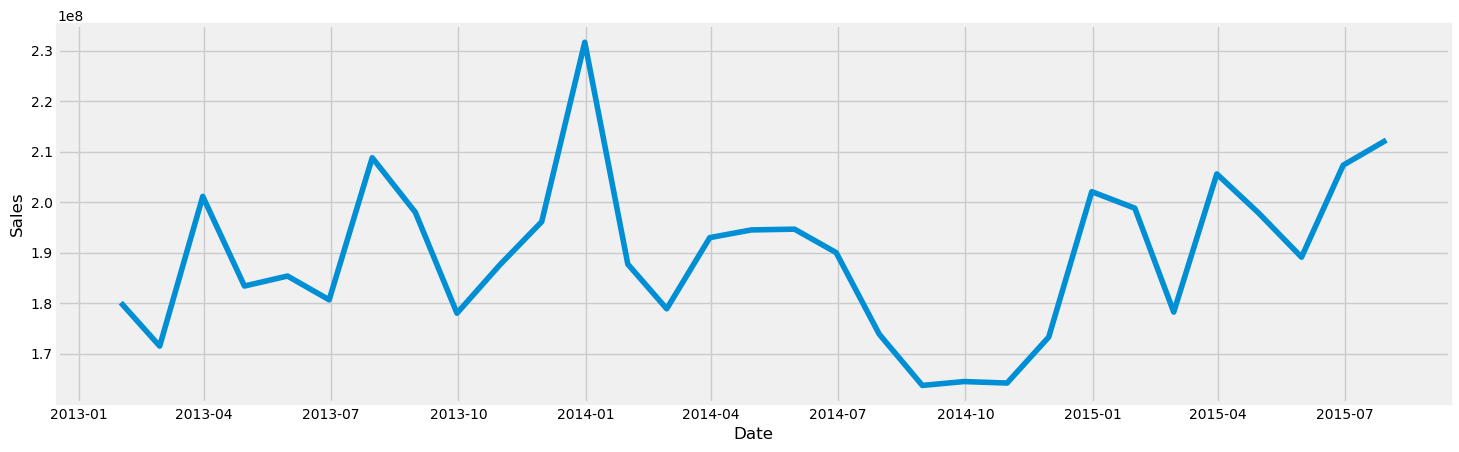

In [20]:
# Let's see how sales series look like
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(train_m, x=train_m.index, y=train_m.Sales) 

In [21]:
# Take a look at train_m
train_m.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Date,,,,,,,
2013-01-31,19286282,134913,180132207,20380423,28869,11150,5115
2013-02-28,17420760,124880,171534275,19244468,26683,11150,2676
2013-03-31,19287270,144950,201180369,21969462,27892,16725,5689
2013-04-30,18665100,128225,183431432,20882365,27880,13380,5319
2013-05-31,19287270,138260,185411063,20723886,26202,14495,3774


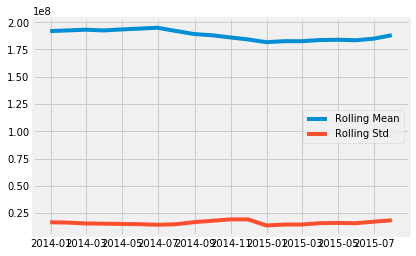

In [31]:
# Using pd.series.rolling to calculate mean and std for Sales series with window=12
# plot mean and std values
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
plt.plot(train_m.Sales.rolling(window=12).mean(), label='Rolling Mean');
plt.plot(train_m.Sales.rolling(window=12).std(), label="Rolling Std");
plt.legend();

## Decomposing time series

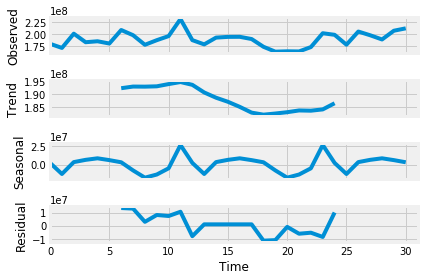

In [33]:
# Import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose Sales with freq=12, model='additive'
res = seasonal_decompose(train_m.Sales.values,freq=12,model="additive")
fig = res.plot();

## Stationary Tests

In [34]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [35]:
# Let's test with original timeseries
test_stationarity(train_m.Sales.values)

Results of Dickey-Fuller Test:
Test Statistic                 -3.544365
p-value                         0.006918
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [54]:
from statsmodels.tsa.arima_model import ARMA
best_aic = np.inf
best_order = None
best_model = None

rng = range(5)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            model = ARMA(ts, order=(i, j)).fit(method='mle', trend='nc')
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

AIC: 690.11 | order: (1, 0)


In [55]:
# Let use diff series with periods is 12 for further steps. Save results in "ts" variable
ts = train_m.Sales.diff(12).dropna()

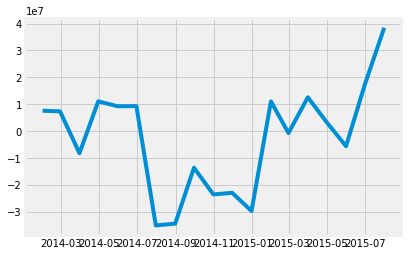

In [56]:
# Let plot and take a look at our series after de-seasonalization
plt.plot(ts);

## 4. Modelling

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

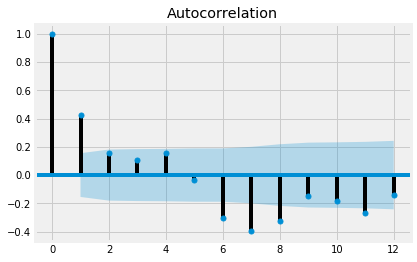

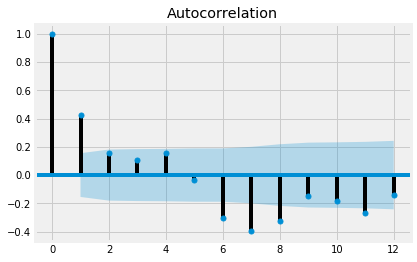

In [51]:
plot_acf(ts, lags=12, alpha=0.5)

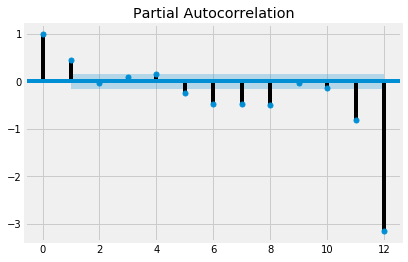

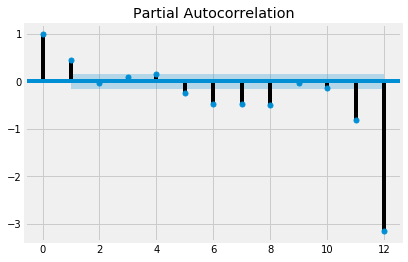

In [52]:
plot_pacf(ts, lags=12, alpha=0.5)

## 5. Summary

In [57]:
predict = best_model.predict(start=0, end=25)

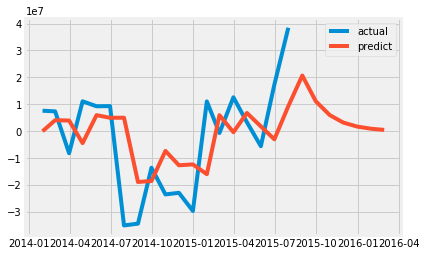

In [58]:
plt.plot(ts, label='actual');
plt.plot(predict, label='predict');
plt.legend()